In [1]:
#Importing all the required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy as sp
from skmultilearn.adapt import MLkNN
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Reading all the files to dataframes
file_1 = pd.read_csv("file_1.csv")
file_2 = pd.read_csv("file_2.csv")
file_3 = pd.read_csv("file_3.csv")
file_4 = pd.read_csv("file_4.csv")

In [3]:
#Checking all the column names
print(file_1.columns,file_2.columns,file_3.columns,file_4.columns)

Index(['title', 'doc_id', 'n_references'], dtype='object') Index(['DOI', 'for_name', 'for_code'], dtype='object') Index(['doi', 'n_authors'], dtype='object') Index(['doi', 'corresponding_author_h_index'], dtype='object')


In [4]:
#Changing names of the columns in files dataframe
file_1 = file_1.rename(columns={'doc_id':'doi'})
file_2 = file_2.rename(columns={'DOI':'doi'})

In [5]:
#Combining data
file_data = [file_1,file_2,file_3,file_4]
#Converting data to string format
for file in file_data:
    file['doi'] = file['doi'].str.upper()


In [6]:
#Combining 'for_code' , 'for_name' and 'corresponding_author_h_index' datain respective dataframes
file_2['for_name'] = file_2['for_name'].astype(str)
new_file_2 = file_2.groupby('doi').apply(lambda x:list(x.for_name))
new_file_2 = new_file_2.to_frame().reset_index()
new_file_2.columns = ['doi','for_name']

file_2['for_code'] = file_2['for_code'].astype(str)
new_file_2_i = file_2.groupby('doi').apply(lambda x:','.join(x.for_code))
new_file_2_i = new_file_2_i.to_frame().reset_index()
new_file_2_i.columns = ['doi','for_code']

file_4['corresponding_author_h_index'] = file_4['corresponding_author_h_index'].astype(str)
new_file_4 = file_4.groupby('doi').apply(lambda x:','.join(x.corresponding_author_h_index))
new_file_4 = new_file_4.to_frame().reset_index()
new_file_4.columns = ['doi','corresponding_author_h_index']


#Combining final data
result_1 = pd.merge(file_1,new_file_2,how='inner',on=['doi'])
result_2 = pd.merge(result_1,new_file_2_i,how='inner',on=['doi'])
result_3 = pd.merge(result_2,file_3,how='inner',on=['doi'])

final = pd.merge(result_3,new_file_4,how='inner',on=['doi'])

In [7]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11276 entries, 0 to 11275
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   title                         11276 non-null  object
 1   doi                           11276 non-null  object
 2   n_references                  11276 non-null  int64 
 3   for_name                      11276 non-null  object
 4   for_code                      11276 non-null  object
 5   n_authors                     11276 non-null  int64 
 6   corresponding_author_h_index  11276 non-null  object
dtypes: int64(2), object(5)
memory usage: 704.8+ KB


In [8]:
#Dividing 'corresponding_author_h_index' data
final[['h_index1','h_index2']] = final['corresponding_author_h_index'].str.split(',',n=1,expand=True)
final[['h_index3','h_index4']] = final['h_index2'].str.split(',',n=1,expand=True)
final[['h_index5','h_index6']] = final['h_index4'].str.split(',',n=1,expand=True)
final[['h_index7','h_index8']] = final['h_index6'].str.split(',',n=1,expand=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11276 entries, 0 to 11275
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   title                         11276 non-null  object
 1   doi                           11276 non-null  object
 2   n_references                  11276 non-null  int64 
 3   for_name                      11276 non-null  object
 4   for_code                      11276 non-null  object
 5   n_authors                     11276 non-null  int64 
 6   corresponding_author_h_index  11276 non-null  object
 7   h_index1                      11276 non-null  object
 8   h_index2                      4481 non-null   object
 9   h_index3                      4481 non-null   object
 10  h_index4                      1082 non-null   object
 11  h_index5                      1082 non-null   object
 12  h_index6                      133 non-null    object
 13  h_index7        

In [9]:
#Removing unnecessary columns
final = final.drop(['corresponding_author_h_index','h_index2','h_index4','h_index6'],axis=1)

In [10]:
#Counting number of fields present
all_fields = sum(final['for_name'],[])
field_count = pd.Series(all_fields).value_counts()
field_count = pd.DataFrame(field_count)
field_count = field_count.reset_index()
field_count.columns = ['field', 'count']

<function matplotlib.pyplot.show(close=None, block=None)>

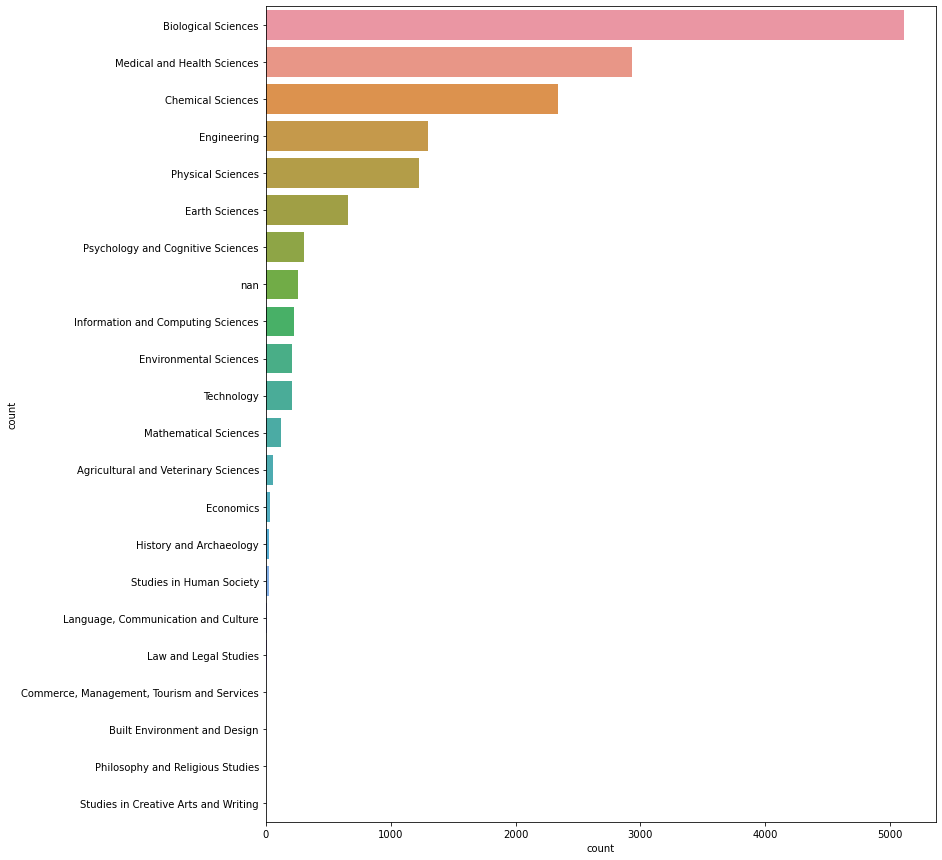

In [11]:
#Plotting the counts
import matplotlib.pyplot as plt
import seaborn as sns
g = field_count.nlargest(columns='count',n=50)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= 'count', y='field')
ax.set(ylabel='count')
plt.show

In [12]:
# Removing Noise (addenda, editorials, corrections (author, publisher), replies, and retractions) from the data
final['for_name_string'] = final['for_name'].apply(lambda x:','.join(map(str,x)))
final = final[final['for_name_string']!='nan']
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11275
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            11016 non-null  object
 1   doi              11016 non-null  object
 2   n_references     11016 non-null  int64 
 3   for_name         11016 non-null  object
 4   for_code         11016 non-null  object
 5   n_authors        11016 non-null  int64 
 6   h_index1         11016 non-null  object
 7   h_index3         4397 non-null   object
 8   h_index5         1060 non-null   object
 9   h_index7         132 non-null    object
 10  h_index8         2 non-null      object
 11  for_name_string  11016 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [13]:
#Converting output fields to one hot encoding vectors
labels = final['for_code'].str.get_dummies(sep=',')
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11275
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1.0     11016 non-null  int64
 1   10.0    11016 non-null  int64
 2   11.0    11016 non-null  int64
 3   12.0    11016 non-null  int64
 4   14.0    11016 non-null  int64
 5   15.0    11016 non-null  int64
 6   16.0    11016 non-null  int64
 7   17.0    11016 non-null  int64
 8   18.0    11016 non-null  int64
 9   19.0    11016 non-null  int64
 10  2.0     11016 non-null  int64
 11  20.0    11016 non-null  int64
 12  21.0    11016 non-null  int64
 13  22.0    11016 non-null  int64
 14  3.0     11016 non-null  int64
 15  4.0     11016 non-null  int64
 16  5.0     11016 non-null  int64
 17  6.0     11016 non-null  int64
 18  7.0     11016 non-null  int64
 19  8.0     11016 non-null  int64
 20  9.0     11016 non-null  int64
dtypes: int64(21)
memory usage: 1.8 MB


In [14]:
# Selecting top occuring classes
column_list = labels.columns
final_columns = ['6.0','11.0','3.0','9.0','2.0','4.0','17.0','8.0','5.0','10.0','1.0','7.0']
for col in column_list:
    if col not in final_columns:
        labels = labels.drop(col,axis=1)

In [15]:
#Concatinating input with the labels
final = pd.concat([final, labels], axis=1)

In [16]:
#Dropping columns
final = final.drop(['doi','for_name','for_code','for_name_string'],axis=1)

In [17]:
#Converting 'h_index' columns to numeric from and filling 'nan' values with 0
h_index = ['h_index1','h_index3','h_index5','h_index7','h_index8']
for h_ind in h_index:
    final[h_ind] = final[h_ind].replace('nan',0).fillna(0)
    final[h_ind] = pd.to_numeric(final[h_ind])

In [18]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11275
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         11016 non-null  object 
 1   n_references  11016 non-null  int64  
 2   n_authors     11016 non-null  int64  
 3   h_index1      11016 non-null  float64
 4   h_index3      11016 non-null  float64
 5   h_index5      11016 non-null  float64
 6   h_index7      11016 non-null  float64
 7   h_index8      11016 non-null  float64
 8   1.0           11016 non-null  int64  
 9   10.0          11016 non-null  int64  
 10  11.0          11016 non-null  int64  
 11  17.0          11016 non-null  int64  
 12  2.0           11016 non-null  int64  
 13  3.0           11016 non-null  int64  
 14  4.0           11016 non-null  int64  
 15  5.0           11016 non-null  int64  
 16  6.0           11016 non-null  int64  
 17  7.0           11016 non-null  int64  
 18  8.0           11016 non-nu

In [19]:
#Splitting data to train and test
train, test = train_test_split(final, random_state=42, test_size=0.30, shuffle=True)
train_x = train.drop(['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0'],axis=1)
train_y = train[['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0']]
test_x = test.drop(['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0'],axis=1)
test_y = test[['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0']]

In [20]:
#Converting text to numerical format
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect.fit(train_x['title'])
vect.fit(test_x['title'])
x_train_vect = vect.transform(train_x['title'])
x_test_vect = vect.transform(test_x['title'])

In [21]:
#Combining vectorized data with the remaining data
old_x_train = train_x[['n_references','n_authors','h_index1','h_index3','h_index5','h_index7','h_index8']]
new_x_train = sp.sparse.hstack((x_train_vect,old_x_train.values),format='csr')
old_x_test = test_x[['n_references','n_authors','h_index1','h_index3','h_index5','h_index7','h_index8']]
new_x_test = sp.sparse.hstack((x_test_vect,old_x_test.values),format='csr')

In [22]:
#Applying adopeted knn for multi-lable classification
classifier = MLkNN(k=12)
classifier.fit(new_x_train, np.array(train_y))
predictions = classifier.predict(new_x_test)

print(accuracy_score(test_y,predictions))
print(classification_report(test_y, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.12526475037821483
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        70
           2       0.45      0.20      0.28       797
           3       1.00      0.01      0.02        89
           4       0.00      0.00      0.00       316
           5       0.41      0.12      0.18       541
           6       0.40      0.03      0.05       145
           7       0.00      0.00      0.00        56
           8       0.50      0.26      0.34      1325
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        62
          11       0.31      0.01      0.02       367

   micro avg       0.47      0.15      0.23      3823
   macro avg       0.26      0.05      0.07      3823
weighted avg       0.39      0.15      0.21      3823
 samples avg       0.16      0.16      0.15      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# using Label Powerset
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(new_x_train, train_y)

# predict
predictions = classifier.predict(new_x_test)

print(accuracy_score(test_y,predictions))
print(classification_report(test_y, predictions))

0.45748865355521934
              precision    recall  f1-score   support

           0       0.17      0.02      0.04        41
           1       0.33      0.03      0.05        70
           2       0.53      0.70      0.60       797
           3       0.58      0.17      0.26        89
           4       0.57      0.54      0.56       316
           5       0.59      0.52      0.56       541
           6       0.73      0.68      0.70       145
           7       0.55      0.21      0.31        56
           8       0.68      0.65      0.67      1325
           9       0.50      0.07      0.12        14
          10       0.25      0.08      0.12        62
          11       0.49      0.44      0.46       367

   micro avg       0.60      0.57      0.58      3823
   macro avg       0.50      0.34      0.37      3823
weighted avg       0.59      0.57      0.57      3823
 samples avg       0.60      0.58      0.57      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(new_x_train, train_y)

# predict
predictions = classifier.predict(new_x_test)

print(accuracy_score(test_y,predictions))
print(classification_report(test_y, predictions))

0.31981845688350985
              precision    recall  f1-score   support

           0       0.14      0.02      0.04        41
           1       0.11      0.04      0.06        70
           2       0.50      0.70      0.58       797
           3       0.44      0.20      0.28        89
           4       0.51      0.55      0.53       316
           5       0.52      0.59      0.55       541
           6       0.67      0.39      0.49       145
           7       0.48      0.20      0.28        56
           8       0.66      0.77      0.71      1325
           9       0.00      0.00      0.00        14
          10       0.09      0.03      0.05        62
          11       0.39      0.49      0.44       367

   micro avg       0.55      0.61      0.58      3823
   macro avg       0.38      0.33      0.33      3823
weighted avg       0.53      0.61      0.56      3823
 samples avg       0.51      0.62      0.53      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
br_classifier = BinaryRelevance(GaussianNB())
br_classifier.fit(new_x_train, train_y)
br_predictions = br_classifier.predict(new_x_test)
print("Accuracy = ",accuracy_score(test_y,br_predictions.toarray()))
print(classification_report(test_y, br_predictions.toarray()))

Accuracy =  0.31981845688350985
              precision    recall  f1-score   support

           0       0.14      0.02      0.04        41
           1       0.11      0.04      0.06        70
           2       0.50      0.70      0.58       797
           3       0.44      0.20      0.28        89
           4       0.50      0.55      0.52       316
           5       0.52      0.59      0.55       541
           6       0.64      0.39      0.48       145
           7       0.46      0.21      0.29        56
           8       0.66      0.77      0.71      1325
           9       0.00      0.00      0.00        14
          10       0.09      0.03      0.05        62
          11       0.39      0.50      0.44       367

   micro avg       0.54      0.61      0.58      3823
   macro avg       0.37      0.33      0.33      3823
weighted avg       0.53      0.61      0.56      3823
 samples avg       0.51      0.62      0.53      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
regressor = RandomForestClassifier(n_estimators = 100, random_state = 0) 
clf = regressor.fit(new_x_train, train_y) 
y_pred=clf.predict(new_x_test)
from sklearn import metrics
from sklearn.metrics import classification_report
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
print(classification_report(test_y, y_pred))

Accuracy: 0.3881996974281392
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        70
           2       0.79      0.40      0.53       797
           3       1.00      0.01      0.02        89
           4       0.82      0.28      0.41       316
           5       0.81      0.35      0.49       541
           6       0.89      0.23      0.37       145
           7       1.00      0.04      0.07        56
           8       0.73      0.73      0.73      1325
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        62
          11       0.71      0.07      0.12       367

   micro avg       0.76      0.42      0.54      3823
   macro avg       0.56      0.18      0.23      3823
weighted avg       0.74      0.42      0.49      3823
 samples avg       0.47      0.44      0.45      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# using classifier chains
classifier = ClassifierChain(DecisionTreeClassifier())
classifier.fit(new_x_train, train_y)
predictions = classifier.predict(new_x_test)
print(accuracy_score(test_y,predictions))
print(classification_report(test_y,predictions))

0.40121028744326775
              precision    recall  f1-score   support

           0       0.11      0.10      0.10        41
           1       0.12      0.09      0.10        70
           2       0.60      0.59      0.59       797
           3       0.42      0.34      0.37        89
           4       0.51      0.49      0.50       316
           5       0.57      0.52      0.54       541
           6       0.61      0.64      0.62       145
           7       0.52      0.54      0.53        56
           8       0.59      0.67      0.63      1325
           9       0.10      0.07      0.08        14
          10       0.23      0.19      0.21        62
          11       0.31      0.30      0.31       367

   micro avg       0.54      0.54      0.54      3823
   macro avg       0.39      0.38      0.38      3823
weighted avg       0.53      0.54      0.53      3823
 samples avg       0.55      0.55      0.53      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Balancing the data

In [28]:
#Applying Label Powerset Tranformation
final['powerlabel'] = final.apply(lambda x : 2048*x["1.0"]+1024*x['10.0']+512*x['11.0']+256*x['17.0']+128*x['2.0']+64*x["3.0"]+32*x['4.0']+16*x['5.0']+8*x['6.0']+4*x['7.0']+2*x['8.0']+4*x['9.0'],axis=1)


<AxesSubplot:>

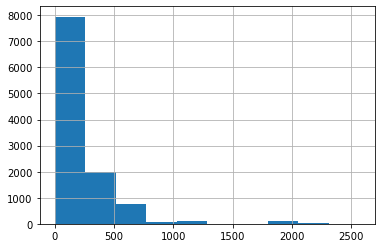

In [29]:
final['powerlabel'].hist()

In [30]:
train, test = train_test_split(final, random_state=42, test_size=0.30, shuffle=True)
powercount = {}
powerlabels = np.unique(train['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(train['powerlabel']==p)
maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    temp_df = train.iloc[np.random.choice(np.where(train['powerlabel']==p)[0],size=gapnum)]
    train = train.append(temp_df,ignore_index=True)
    
train_after = train.sample(frac=1).reset_index(drop=True)

<AxesSubplot:>

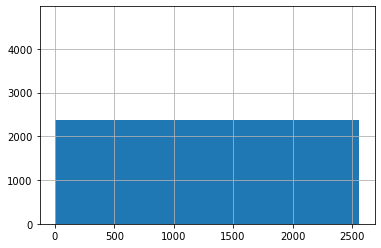

In [31]:
train_after['powerlabel'].hist(bins=np.unique(train_after['powerlabel']))

In [32]:
train_x = train.drop(['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','powerlabel'],axis=1)
train_y = train[['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0']]
test_x = test.drop(['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','powerlabel'],axis=1)
test_y = test[['1.0','10.0','11.0','17.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0']]

In [33]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect.fit(train_x['title'])
vect.fit(test_x['title'])
x_train_vect = vect.transform(train_x['title'])
x_test_vect = vect.transform(test_x['title'])
old_x_train = train_x[['n_references','n_authors','h_index1','h_index3','h_index5','h_index7','h_index8']]
import scipy as sp
new_x_train = sp.sparse.hstack((x_train_vect,old_x_train.values),format='csr')
old_x_test = test_x[['n_references','n_authors','h_index1','h_index3','h_index5','h_index7','h_index8']]
new_x_test = sp.sparse.hstack((x_test_vect,old_x_test.values),format='csr')

In [34]:
# using Label Powerset
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(new_x_train, train_y)

# predict
predictions = classifier.predict(new_x_test)

print(accuracy_score(test_y,predictions))
print(classification_report(test_y, predictions))


0.46202723146747354
              precision    recall  f1-score   support

           0       0.17      0.02      0.04        41
           1       0.33      0.03      0.05        70
           2       0.54      0.69      0.61       797
           3       0.58      0.17      0.26        89
           4       0.58      0.54      0.56       316
           5       0.60      0.53      0.56       541
           6       0.73      0.68      0.70       145
           7       0.55      0.21      0.31        56
           8       0.68      0.66      0.67      1325
           9       0.50      0.07      0.12        14
          10       0.25      0.08      0.12        62
          11       0.50      0.44      0.47       367

   micro avg       0.60      0.57      0.59      3823
   macro avg       0.50      0.34      0.37      3823
weighted avg       0.59      0.57      0.57      3823
 samples avg       0.60      0.58      0.58      3823



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
